# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [288]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import os
import csv
from datetime import datetime #for converting Unix UTC datetime to human-readable date

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [289]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

638

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it's being processed (with the city number and city name).


In [290]:
api = weather_api_key
# Build query URL
url = "http://api.openweathermap.org/data/2.5/weather?"

def APIRequest(cityNumber):#function for making the API call to OpenWeatherMap.org and returning the data
    query_url = url + "appid=" + api + "&q=" + cities[cityNumber-1] + "&units=imperial"
    responseJson = requests.get(query_url).json() #making the API request and grabbing the JSON from the response

    if ("'message': 'city not found'" in str(responseJson)): #checking response JSON for the string of text containing the message 'city not found'
        full_City_Data.append("NaN")#if the city is not found, append a NaN value (makes dropping items with pandas easier later) to the lists to keep the index numbers correct
        city_City_Data.append("NaN")#list for city names
        lat_City_Data.append("NaN")#list for city latitude
        lng_City_Data.append("NaN")#list for city longitude
        max_Temp_City_Data.append("NaN")#list for city maximum temperature
        humidity_City_Data.append("NaN")#list for city humidity
        cloudiness_City_Data.append("NaN")#list for city cloudiness amount
        wind_Speed_City_Data.append("NaN")#list for city wind speed amount
        country_City_Data.append("NaN")#list for which country a city is in
        date_City_Data.append("NaN")#list for the datetime information stored in unix UTC format
        print("City not found. Skipping...")
    else:
        full_City_Data.append(responseJson) #if the city is found, do append the information to the lists
        city_City_Data.append(responseJson["name"])
        lat_City_Data.append(responseJson["coord"]["lat"])
        lng_City_Data.append(responseJson["coord"]["lat"])
        max_Temp_City_Data.append(responseJson["main"]["temp_max"])
        humidity_City_Data.append(responseJson["main"]["humidity"])
        cloudiness_City_Data.append(responseJson["clouds"]["all"])
        wind_Speed_City_Data.append(responseJson["wind"]["speed"])
        country_City_Data.append(responseJson["sys"]["country"])
        date_City_Data.append(responseJson["dt"])
        #convert the datetime in unix UTC format to human-readable format. I only need one not null value from this list; all API calls are made on the same date
        converted_Date.append(datetime.utcfromtimestamp(responseJson["dt"]).strftime('%m-%d-%Y')) #only in the else block to prevent null values

#if length of cities is exactly divisible by 50 then get the length. else we need to add an extra batch to account for the remainder
remainder = 0
if (len(cities) % 50 == 0):
        totalBatches = int(len(cities) / 50) #doing batches of 50 API calls at once; finding the total number of batches I will be making
else:
    totalBatches = int((len(cities) / 50)+1)
    remainder = int(len(cities) % 50)
    
batchCounter = 1
requestsPerBatch = 50
requestCounter = 1
cityNumber = 1
#creating empty lists to use to append each piece of the weather data response to
full_City_Data, city_City_Data, lat_City_Data, lng_City_Data, max_Temp_City_Data, humidity_City_Data, cloudiness_City_Data, wind_Speed_City_Data, country_City_Data, date_City_Data, converted_Date = [], [], [], [], [], [], [], [], [], [], []

print("Beginning Data Retrieval\n-----------------------------")
while (batchCounter <= totalBatches): 
    print(f"Starting batch {batchCounter} of {totalBatches}.")
    while ((batchCounter != totalBatches) & (requestCounter <= requestsPerBatch)): #if we're not on the final batch, run this code
        cityNumber = (50 * (batchCounter-1)) + requestCounter #calculating city number        
        APIRequest(cityNumber)
        if (city_City_Data[cityNumber-1] != "NaN"):#if any of lists at this element are blank, skip printing the name and move onto the next city
            print(f"Request {requestCounter} of batch {batchCounter}. City number: {cityNumber} City name: {city_City_Data[cityNumber-1]}.")
        requestCounter +=1
    while ((batchCounter == totalBatches) & (requestCounter <= remainder)): #if we are on the final batch, run this code
        cityNumber = (50 * (batchCounter-1)) + requestCounter #calculating city number
        APIRequest(cityNumber)
        if (city_City_Data[cityNumber-1] != "NaN"):#if any of lists at this element are blank, skip printing the name and move onto the next city
            print(f"Request {requestCounter} of batch {batchCounter}. City number: {cityNumber} City name: {city_City_Data[cityNumber-1]}.")
        requestCounter +=1        
    batchCounter +=1
    requestCounter = 1 #resetting requestCounter so it will hit the inner while loop again in the next iteration of the outer while loop
    
print("-----------------------------\nData Retrieval Complete\n----------------------------") 

Beginning Data Retrieval
-----------------------------
Starting batch 1 of 13.
Request 1 of batch 1. City number: 1 City name: Praia da Vitória.
Request 2 of batch 1. City number: 2 City name: Hadejia.
Request 3 of batch 1. City number: 3 City name: Prince Rupert.
Request 4 of batch 1. City number: 4 City name: Davila.
Request 5 of batch 1. City number: 5 City name: Pisco.
Request 6 of batch 1. City number: 6 City name: Hermanus.
Request 7 of batch 1. City number: 7 City name: Karratha.
Request 8 of batch 1. City number: 8 City name: Pevek.
Request 9 of batch 1. City number: 9 City name: Tiksi.
Request 10 of batch 1. City number: 10 City name: Fortuna.
Request 11 of batch 1. City number: 11 City name: Rikitea.
Request 12 of batch 1. City number: 12 City name: Ueda.
Request 13 of batch 1. City number: 13 City name: Jamestown.
Request 14 of batch 1. City number: 14 City name: Puerto Ayora.
Request 15 of batch 1. City number: 15 City name: Flinders.
Request 16 of batch 1. City number: 16 

Request 40 of batch 3. City number: 140 City name: Hilo.
Request 41 of batch 3. City number: 141 City name: Kruisfontein.
Request 42 of batch 3. City number: 142 City name: Lichuan.
Request 43 of batch 3. City number: 143 City name: Cape Town.
Request 44 of batch 3. City number: 144 City name: Nichinan.
City not found. Skipping...
Request 46 of batch 3. City number: 146 City name: Nabire.
Request 47 of batch 3. City number: 147 City name: Ouadda.
Request 48 of batch 3. City number: 148 City name: Dawson Creek.
City not found. Skipping...
Request 50 of batch 3. City number: 150 City name: Kongsberg.
Starting batch 4 of 13.
Request 1 of batch 4. City number: 151 City name: Matamoros.
Request 2 of batch 4. City number: 152 City name: Codajás.
Request 3 of batch 4. City number: 153 City name: Sur.
Request 4 of batch 4. City number: 154 City name: Airai.
Request 5 of batch 4. City number: 155 City name: Nanortalik.
Request 6 of batch 4. City number: 156 City name: Katsuura.
Request 7 of bat

Request 27 of batch 6. City number: 277 City name: Bowen.
Request 28 of batch 6. City number: 278 City name: Geraldton.
Request 29 of batch 6. City number: 279 City name: Hammerfest.
Request 30 of batch 6. City number: 280 City name: Le Vauclin.
Request 31 of batch 6. City number: 281 City name: Coquimbo.
Request 32 of batch 6. City number: 282 City name: Miramar.
Request 33 of batch 6. City number: 283 City name: Mahébourg.
Request 34 of batch 6. City number: 284 City name: Chemodanovka.
Request 35 of batch 6. City number: 285 City name: Sangar.
Request 36 of batch 6. City number: 286 City name: Tadine.
Request 37 of batch 6. City number: 287 City name: Ropczyce.
Request 38 of batch 6. City number: 288 City name: Narsaq.
Request 39 of batch 6. City number: 289 City name: Cap Malheureux.
Request 40 of batch 6. City number: 290 City name: Havøysund.
Request 41 of batch 6. City number: 291 City name: Kahului.
Request 42 of batch 6. City number: 292 City name: Rocha.
Request 43 of batch 6

Request 15 of batch 9. City number: 415 City name: Trairi.
Request 16 of batch 9. City number: 416 City name: Savelugu.
Request 17 of batch 9. City number: 417 City name: Baharly.
Request 18 of batch 9. City number: 418 City name: Lompoc.
Request 19 of batch 9. City number: 419 City name: Waingapu.
Request 20 of batch 9. City number: 420 City name: Port-Cartier.
Request 21 of batch 9. City number: 421 City name: Coyhaique.
Request 22 of batch 9. City number: 422 City name: Dapaong.
Request 23 of batch 9. City number: 423 City name: Amazar.
Request 24 of batch 9. City number: 424 City name: Oruzgan.
Request 25 of batch 9. City number: 425 City name: Haines Junction.
Request 26 of batch 9. City number: 426 City name: Lamu.
Request 27 of batch 9. City number: 427 City name: Annau.
City not found. Skipping...
Request 29 of batch 9. City number: 429 City name: Chifeng.
Request 30 of batch 9. City number: 430 City name: Eydhafushi.
Request 31 of batch 9. City number: 431 City name: Luganvill

Request 3 of batch 12. City number: 553 City name: Aripuanã.
Request 4 of batch 12. City number: 554 City name: Kingman.
Request 5 of batch 12. City number: 555 City name: Villa Guerrero.
Request 6 of batch 12. City number: 556 City name: Wewak.
Request 7 of batch 12. City number: 557 City name: Hoquiam.
Request 8 of batch 12. City number: 558 City name: Palu.
Request 9 of batch 12. City number: 559 City name: Sainte-Rose.
City not found. Skipping...
Request 11 of batch 12. City number: 561 City name: Pochutla.
Request 12 of batch 12. City number: 562 City name: Hay River.
Request 13 of batch 12. City number: 563 City name: Kirkwall.
City not found. Skipping...
Request 15 of batch 12. City number: 565 City name: Xining.
Request 16 of batch 12. City number: 566 City name: Washougal.
Request 17 of batch 12. City number: 567 City name: Pandharpur.
Request 18 of batch 12. City number: 568 City name: Ashland.
Request 19 of batch 12. City number: 569 City name: Barentu.
Request 20 of batch 1

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [291]:
#use each individual list as a column in the data frame
weather_df = pd.DataFrame(data={"City": city_City_Data, "Lat": lat_City_Data, "Lng": lng_City_Data, "Max Temp": max_Temp_City_Data, "Humidity": humidity_City_Data, "Cloudiness": cloudiness_City_Data, "Wind Speed": wind_Speed_City_Data, "Country": country_City_Data, "Date": date_City_Data})

output_path = os.path.join("Output", "output.csv")
weather_df.to_csv(output_path, sep=',',index=False)#write the data frame to a CSV

weather_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Praia da Vitória,38.73,38.73,60.8,51,40,16.78,PT,1607987904
1,Hadejia,12.45,12.45,74.05,19,0,9.95,NG,1607987904
2,Prince Rupert,54.32,54.32,42.8,86,75,11.41,CA,1607987698
3,Davila,18.47,18.47,78.8,78,75,4.7,PH,1607987904
4,Pisco,-13.7,-13.7,69.8,77,75,19.46,PE,1607987904


In [292]:
cleaned_weather_df = weather_df.drop(columns=["City", "Country"]) #drop the non-numeric data from the data frame
#convert all columns to floats so I can drop the NaN values with pandas
cleaned_weather_df[["Lat", "Lng", "Max Temp", "Humidity", "Cloudiness", "Wind Speed", "Date"]] = cleaned_weather_df[["Lat", "Lng", "Max Temp", "Humidity", "Cloudiness", "Wind Speed", "Date"]].astype(float)
cleaned_weather_df.dropna(axis=0,how='all', inplace=True)#drop all NaN items from data frame

cleaned_weather_df.describe() #summarize the remaining numeric data

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,5.910000e+02
mean,21.648816,21.648816,49.141472,75.666667,53.296108,8.087716,1.607988e+09
std,32.312173,32.312173,30.473390,17.700203,38.801607,5.849682,5.964054e+01
min,-54.800000,-54.800000,-55.500000,15.000000,0.000000,0.380000,1.607988e+09
25%,-3.645000,-3.645000,29.920000,69.000000,12.000000,3.665000,1.607988e+09
50%,27.980000,27.980000,58.120000,79.000000,62.000000,6.670000,1.607988e+09
75%,48.145000,48.145000,75.200000,89.000000,90.000000,10.830000,1.607988e+09
max,78.220000,78.220000,89.600000,100.000000,100.000000,32.210000,1.607988e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [293]:
# no cities had a humidity of over 100%.

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

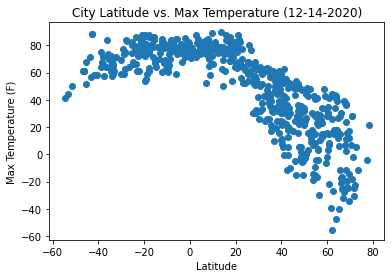

In [294]:
plt.scatter(cleaned_weather_df["Lat"], cleaned_weather_df["Max Temp"])
plt.title(f"City Latitude vs. Max Temperature ({converted_Date[0]})")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.show()

## Latitude vs. Humidity Plot

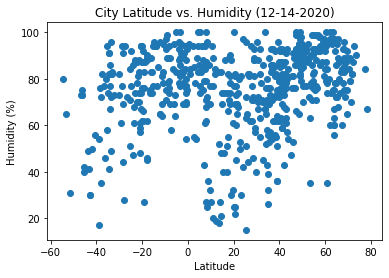

In [295]:
plt.scatter(cleaned_weather_df["Lat"], cleaned_weather_df["Humidity"])
plt.title(f"City Latitude vs. Humidity ({converted_Date[0]})")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.show()

## Latitude vs. Cloudiness Plot

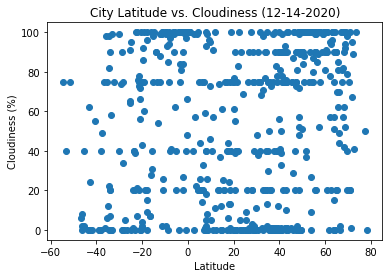

In [296]:
plt.scatter(cleaned_weather_df["Lat"], cleaned_weather_df["Cloudiness"])
plt.title(f"City Latitude vs. Cloudiness ({converted_Date[0]})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.show()

## Latitude vs. Wind Speed Plot

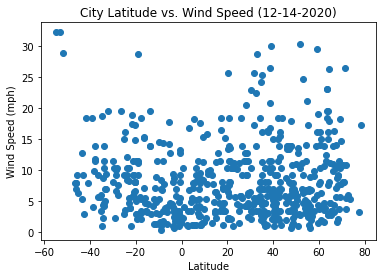

In [297]:
plt.scatter(cleaned_weather_df["Lat"], cleaned_weather_df["Wind Speed"])
plt.title(f"City Latitude vs. Wind Speed ({converted_Date[0]})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.show()

## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

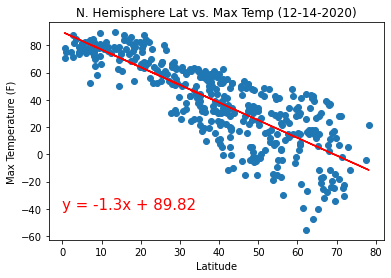

The R value is:-0.815178512150926


In [311]:
northern_hemisphere_df = cleaned_weather_df
#check to see if the latitude is greater than or equal to 0 degrees; if so, then the city must be in the northern hemisphere
northern_hemisphere_df['Lat'] = cleaned_weather_df[cleaned_weather_df['Lat'] >= 0]
northern_hemisphere_df.dropna(axis=0,how='any', inplace=True) #removing any of the cities that are in the southern hemisphere

(slope, intercept, rvalue, pvalue, stderr) = linregress(northern_hemisphere_df["Lat"], northern_hemisphere_df["Max Temp"]) #extracting values for the linear regression model
regress_values = northern_hemisphere_df["Lat"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)) #storing the line equation to allow for manual calculations using formula

plt.scatter(northern_hemisphere_df["Lat"], northern_hemisphere_df["Max Temp"]) #creating the initial scatter plot
plt.plot(northern_hemisphere_df["Lat"],regress_values,"r-") #plot the regression line on the chart
plt.annotate(line_eq,(0,-40),fontsize=15,color="red") #add the formula the regression line is using to the chart at location (0,-40) on the chart

plt.title(f"N. Hemisphere Lat vs. Max Temp ({converted_Date[0]})")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.show()

print(f"The r-value is: {rvalue}")

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression